# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1 Project Definition
## 1.1 Project Overview
As a company, it is important to have an efficient promotional spend that can maximize revenue, while maintaining promotional cost as low as possible. One of the way to achieve the goals is by understanding the customer behavior to know which promotion works for which segment. Creating tailored offering based on specific customer traits will hopefully increase the return in promotional spend.
## 1.2 Problem Statement
### 1.2.1 Identify which groups of people are most responsive to each type of offer? <br> 
First I'd like to create a customer segmentation by creating relevant features of each customers.
 * Engineered features for each customers by processing transcript and portfolio
 * Run K-Means clustering method to identify the optimal grouping
 * Create descriptive statistics for each group and visualisations

### 1.2.2 How best to present each type of offer ?
For each cluster, I'd like to estimates the likelihood of its being redeemed. Repesented by total offer completed/offer received where offer received is equal to total number of person in the cluster. 

## 1.3 Metrics 
For 1.2.2 is elbow <br>
For 1.2.3 is accuracy

# 2 Analysis
## 2.1 Exploration and Visualization

In [52]:
# import libraries

import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from numpy import nansum
from numpy import nanmean


# magic word for producing visualizations in notebook
%matplotlib inline

In [1]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
def quick_diagnostics (df):
    # Quick diagnostic
    print("Shape :", df.shape)
    print("\nFeatures :", df.columns.tolist())
    print("\nNull values :\n", df.isnull().sum())
    print("\nUnique values :\n", df.nunique())
    print("\nData formating:\n",df.info())
    print("\nDescriptive statistics:\n", df.describe(include="all"))

In [2]:
display(profile.head(5))
display(portfolio.head(5))
display(transcript.tail(5))

age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5

event                            person  time  \
306529  transaction  b3a1272bc9904337b331bf348c3e8c17   714   
306530  transaction  68213b08d99a4ae1b0dcb72aebd9aa35   714   
306531  transaction  a00058cf10334a308c68e7631c529907   714   
306532  transaction  76ddbd6576844afe811f1a3c0fbb5bec   714   
306533  transaction  c02b10e8752c4d8e9b73f918558531f7   714   

                                 value  
306529  {'amount': 1.5899999999999999}  
306530                {'amount': 9.53}  
306531                {'amount': 3.61}  
306532  {'amount': 3.5300000000000002}  
306533                {'amount': 4.05}

### 2.1.1 Reformat table

__Formating :__
* profile : reformat date, replace unified null values identificator
* portfolio : break channels into columns
* transcript : break value into columns

In [4]:
# Reformat profile - format age missing value (1/2)
profile_formatted = profile.copy()

boolean = profile_formatted.age>100
print(profile_formatted[boolean].age.value_counts())

profile_formatted.age = profile_formatted.age.replace(118,np.NaN)

print(profile_formatted[boolean].age.value_counts())

118    2175
101       5
Name: age, dtype: int64
101.0    5
Name: age, dtype: int64


In [5]:
# Reformat profile - format date time (2/2)

profile_formatted.became_member_on = profile.became_member_on.apply(
    lambda x :datetime.strptime(str(x), '%Y%m%d').date())

display(profile_formatted.head(5))

age became_member_on gender                                id    income
0   NaN       2017-02-12   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1  55.0       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2   NaN       2018-07-12   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3  75.0       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4   NaN       2017-08-04   None  a03223e636434f42ac4c3df47e8bac43       NaN

In [6]:
# Reformat portfolio
mlb = MultiLabelBinarizer()

transformed_column = portfolio.channels
portfolio_formatted = portfolio.join(
    pd.DataFrame(
        mlb.fit_transform(transformed_column),
        columns=mlb.classes_,
        index=portfolio.index)).drop(['channels'], axis =1)

display(portfolio_formatted)

difficulty  duration                                id     offer_type  \
0          10         7  ae264e3637204a6fb9bb56bc8210ddfd           bogo   
1          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo   
2           0         4  3f207df678b143eea3cee63160fa8bed  informational   
3           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo   
4          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount   
5           7         7  2298d6c36e964ae4a3e7e9706d1fb8c2       discount   
6          10        10  fafdcd668e3743c1bb461111dcafc2a4       discount   
7           0         3  5a8bc65990b245e5a138643cd4eb9837  informational   
8           5         5  f19421c1d4aa40978ebb69ca19b0e20d           bogo   
9          10         7  2906b810c7d4411798c6938adc9daaa5       discount   

   reward  email  mobile  social  web  
0      10      1       1       1    0  
1      10      1       1       1    1  
2       0      1       1       0    1  
3       5      1       1       0    1  
4       5      1       0       0    1  
5       3      1       1       1    1  
6       2      1       1       1    1  
7       0      1       1       1    0  
8       5      1       1       1    1  
9       2      1       1       0    1

In [7]:
# Reformat transcript

transcript_formatted = transcript.join(
    pd.DataFrame(
        pd.io.json.json_normalize(transcript.value),
        index=transcript.index)).drop(['value'], axis =1)

# Rename column to avoid confusion
transcript_formatted = transcript_formatted.rename(columns={
    "offer id" : "offer_id",
    "offer_id":"completed_offer_id",
    "reward":"reward_received"
}) 


# Merge offer_id column with completed_offer_id
transcript_formatted.offer_id.fillna(transcript_formatted.completed_offer_id, inplace=True)

display(transcript_formatted.head(5))

event                            person  time  amount  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0     NaN   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0     NaN   
2  offer received  e2127556f4f64592b11af22de27a7932     0     NaN   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0     NaN   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0     NaN   

                           offer_id completed_offer_id  reward_received  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                NaN              NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7                NaN              NaN  
2  2906b810c7d4411798c6938adc9daaa5                NaN              NaN  
3  fafdcd668e3743c1bb461111dcafc2a4                NaN              NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0                NaN              NaN

### 2.1.2 EDA

### 2.1.3 Aggregate data 

Combined all the table, anchoring at transcript.

In [8]:
# Left join transcript and profile
agg = pd.merge(transcript_formatted, profile_formatted, left_on="person", right_on="id", how='left').drop(["id"],axis=1)

print("check transcript shape :",transcript_formatted.shape)
print("check profile :",profile_formatted.shape)
print("check aggregate shape :",agg.shape)
print("chech unique id :",agg.person.nunique())

display(agg.head(10))

check transcript shape : (306534, 7)
check profile : (17000, 5)
check aggregate shape : (306534, 11)
chech unique id : 17000


event                            person  time  amount  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0     NaN   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0     NaN   
2  offer received  e2127556f4f64592b11af22de27a7932     0     NaN   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0     NaN   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0     NaN   
5  offer received  389bc3fa690240e798340f5a15918d5c     0     NaN   
6  offer received  c4863c7985cf408faee930f111475da3     0     NaN   
7  offer received  2eeac8d8feae4a8cad5a6af0499a211d     0     NaN   
8  offer received  aa4862eba776480b8bb9c68455b8c2e1     0     NaN   
9  offer received  31dda685af34476cad5bc968bdb01c53     0     NaN   

                           offer_id completed_offer_id  reward_received   age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                NaN              NaN  75.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7                NaN              NaN   NaN   
2  2906b810c7d4411798c6938adc9daaa5                NaN              NaN  68.0   
3  fafdcd668e3743c1bb461111dcafc2a4                NaN              NaN   NaN   
4  4d5c57ea9a6940dd891ad53e9dbe8da0                NaN              NaN   NaN   
5  f19421c1d4aa40978ebb69ca19b0e20d                NaN              NaN  65.0   
6  2298d6c36e964ae4a3e7e9706d1fb8c2                NaN              NaN   NaN   
7  3f207df678b143eea3cee63160fa8bed                NaN              NaN  58.0   
8  0b1e1539f2cc45b7b9fa7c272da2e1d7                NaN              NaN  61.0   
9  0b1e1539f2cc45b7b9fa7c272da2e1d7                NaN              NaN  62.0   

  became_member_on gender    income  
0       2017-05-09      F  100000.0  
1       2017-08-04   None       NaN  
2       2018-04-26      M   70000.0  
3       2017-09-25   None       NaN  
4       2017-10-02   None       NaN  
5       2018-02-09      M   53000.0  
6       2017-08-24   None       NaN  
7       2017-11-11      M   51000.0  
8       2017-09-11      F   57000.0  
9       2016-02-11      F   71000.0

In [9]:
# Left join agg and portfolio
agg2 = pd.merge(agg,portfolio_formatted, left_on="offer_id", right_on="id", how='left').drop(["id"],axis=1)

print("check transcript shape :",agg.shape)
print("check profile :",portfolio_formatted.shape)
print("check aggregate shape :",agg2.shape)
print("chech unique id :",agg2.offer_id.nunique())

display(agg2.head(10))

check transcript shape : (306534, 11)
check profile : (10, 9)
check aggregate shape : (306534, 19)
chech unique id : 10


event                            person  time  amount  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0     NaN   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0     NaN   
2  offer received  e2127556f4f64592b11af22de27a7932     0     NaN   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0     NaN   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0     NaN   
5  offer received  389bc3fa690240e798340f5a15918d5c     0     NaN   
6  offer received  c4863c7985cf408faee930f111475da3     0     NaN   
7  offer received  2eeac8d8feae4a8cad5a6af0499a211d     0     NaN   
8  offer received  aa4862eba776480b8bb9c68455b8c2e1     0     NaN   
9  offer received  31dda685af34476cad5bc968bdb01c53     0     NaN   

                           offer_id completed_offer_id  reward_received   age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                NaN              NaN  75.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7                NaN              NaN   NaN   
2  2906b810c7d4411798c6938adc9daaa5                NaN              NaN  68.0   
3  fafdcd668e3743c1bb461111dcafc2a4                NaN              NaN   NaN   
4  4d5c57ea9a6940dd891ad53e9dbe8da0                NaN              NaN   NaN   
5  f19421c1d4aa40978ebb69ca19b0e20d                NaN              NaN  65.0   
6  2298d6c36e964ae4a3e7e9706d1fb8c2                NaN              NaN   NaN   
7  3f207df678b143eea3cee63160fa8bed                NaN              NaN  58.0   
8  0b1e1539f2cc45b7b9fa7c272da2e1d7                NaN              NaN  61.0   
9  0b1e1539f2cc45b7b9fa7c272da2e1d7                NaN              NaN  62.0   

  became_member_on gender    income  difficulty  duration     offer_type  \
0       2017-05-09      F  100000.0         5.0       7.0           bogo   
1       2017-08-04   None       NaN        20.0      10.0       discount   
2       2018-04-26      M   70000.0        10.0       7.0       discount   
3       2017-09-25   None       NaN        10.0      10.0       discount   
4       2017-10-02   None       NaN        10.0       5.0           bogo   
5       2018-02-09      M   53000.0         5.0       5.0           bogo   
6       2017-08-24   None       NaN         7.0       7.0       discount   
7       2017-11-11      M   51000.0         0.0       4.0  informational   
8       2017-09-11      F   57000.0        20.0      10.0       discount   
9       2016-02-11      F   71000.0        20.0      10.0       discount   

   reward  email  mobile  social  web  
0     5.0    1.0     1.0     0.0  1.0  
1     5.0    1.0     0.0     0.0  1.0  
2     2.0    1.0     1.0     0.0  1.0  
3     2.0    1.0     1.0     1.0  1.0  
4    10.0    1.0     1.0     1.0  1.0  
5     5.0    1.0     1.0     1.0  1.0  
6     3.0    1.0     1.0     1.0  1.0  
7     0.0    1.0     1.0     0.0  1.0  
8     5.0    1.0     0.0     0.0  1.0  
9     5.0    1.0     0.0     0.0  1.0

### 2.1.4 Analyze customer purchasing behavior

In [192]:
customer = agg2.copy()

#### 2.1.4.1 Fill missing value with MOD for age, income, and gender column

In [193]:
# Fill missing value

# Age - fill na with mod
customer.age.fillna(agg2['age'].mode()[0], inplace=True)
print("age null value before :",agg2.age.isnull().sum(),"\nage null value after :", customer.age.isnull().sum())

# Income - fill na with mod
customer.income.fillna(agg2['income'].mode()[0], inplace=True)
print("\nincome null value before :",agg2.age.isnull().sum(),"\nincome null value after :", customer.age.isnull().sum())

# Gender - fill na with mod - To be encoded later
customer.gender.fillna(agg2['gender'].mode()[0], inplace=True)
print("\ngender null value before :",agg2.age.isnull().sum(),"\ngender null value after :", customer.age.isnull().sum())

customer.head(5)

age null value before : 33772 
age null value after : 0

income null value before : 33772 
income null value after : 0

gender null value before : 33772 
gender null value after : 0


event                            person  time  amount  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0     NaN   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0     NaN   
2  offer received  e2127556f4f64592b11af22de27a7932     0     NaN   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0     NaN   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0     NaN   

                           offer_id completed_offer_id  reward_received   age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                NaN              NaN  75.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7                NaN              NaN  58.0   
2  2906b810c7d4411798c6938adc9daaa5                NaN              NaN  68.0   
3  fafdcd668e3743c1bb461111dcafc2a4                NaN              NaN  58.0   
4  4d5c57ea9a6940dd891ad53e9dbe8da0                NaN              NaN  58.0   

  became_member_on gender    income  difficulty  duration offer_type  reward  \
0       2017-05-09      F  100000.0         5.0       7.0       bogo     5.0   
1       2017-08-04      M   73000.0        20.0      10.0   discount     5.0   
2       2018-04-26      M   70000.0        10.0       7.0   discount     2.0   
3       2017-09-25      M   73000.0        10.0      10.0   discount     2.0   
4       2017-10-02      M   73000.0        10.0       5.0       bogo    10.0   

   email  mobile  social  web  
0    1.0     1.0     0.0  1.0  
1    1.0     0.0     0.0  1.0  
2    1.0     1.0     0.0  1.0  
3    1.0     1.0     1.0  1.0  
4    1.0     1.0     1.0  1.0

#### 2.1.4.2 Engineered new features for customers
`1.` Total item by event types (promotion viewed, completed, etc.)<br>
`2.` Total and average of amount spend and rewards received<br>
`3.` Total and rate of events by promotions type, difficulty, duration, and reward<br>
`4.` Total and rate of events by promotion channel<br>

In [194]:
# Feature engineering - total events per customer

def sum_offer_received(trx):
    return np.sum(trx=="offer received")
def sum_offer_viewed(trx):
    return np.sum(trx=="offer viewed")
def sum_offer_completed(trx):
    return np.sum(trx=="offer completed")
def sum_transaction(trx):
    return np.sum(trx=="transaction")

def rating_generator1(dfsource,anchor,var,dftotal,dfrate) :
    if(not isinstance(dfsource[var][1], str)) :
        dfsource[var].fillna(0,inplace=True)
        dfsource[var]= dfsource[var].astype(int).astype(str)

    df= dfsource.groupby([anchor, var]).agg({
        'event':[sum_offer_received,sum_offer_completed],
            })
    df.columns = ["_".join(x) for x in df.columns.ravel()]
    df = df.unstack()
    df.columns = ["_".join(x) for x in df.columns.ravel()]
    print(var)
    
    dftemp = pd.merge(dftotal, df, on="person", how='left')

    type = dfsource[var].value_counts().index
    if(not isinstance(dfsource[var][1], str)) : type= type.astype(int).astype(str)

    for i in type :
        col_name = var+'_rate_'+i
        completed = 'event_sum_offer_completed_'+i
        received = 'event_sum_offer_received_'+i
        dfrate[col_name] = df[completed]/df[received]
    
    return dftemp

def rating_generator2(dfsource,anchor,var,dftotal,dfrate):
    df= dfsource[dfsource[var]==1].groupby([anchor]).agg({
        'event':[sum_offer_received,sum_offer_completed],
            })
    df.columns = ["_".join(x)+"_"+var for x in df.columns.ravel()]
    dftemp = pd.merge(dftotal, df, on="person", how='left')
    
    col_name = var+'_rate'
    completed = 'event_sum_offer_completed_'+var
    received = 'event_sum_offer_received_'+var
    dfrate[col_name] = df[completed]/df[received]
    
    return dftemp

In [195]:
dfsource = customer.copy()
dfrate = pd.DataFrame()

In [196]:
dftotal = dfsource.groupby(['person']).agg({   
    'event': [sum_offer_received,sum_offer_viewed,sum_offer_completed,sum_transaction],
    'reward_received' :[nansum,nanmean],
    'amount' :[nansum,nanmean]
})
dftotal.columns = ["_".join(x) for x in dftotal.columns.ravel()]
dftotal['completed_rate'] = dftotal['event_sum_offer_completed']/dftotal['event_sum_offer_received']

display(dftotal.head(5))

event_sum_offer_received  \
person                                                       
0009655768c64bdeb2e877511632db8f                         5   
00116118485d4dfda04fdbaba9a87b5c                         2   
0011e0d4e6b944f998e987f904e8c1e5                         5   
0020c2b971eb4e9188eac86d93036a77                         5   
0020ccbbb6d84e358d3414a3ff76cffd                         4   

                                  event_sum_offer_viewed  \
person                                                     
0009655768c64bdeb2e877511632db8f                       4   
00116118485d4dfda04fdbaba9a87b5c                       2   
0011e0d4e6b944f998e987f904e8c1e5                       5   
0020c2b971eb4e9188eac86d93036a77                       3   
0020ccbbb6d84e358d3414a3ff76cffd                       4   

                                  event_sum_offer_completed  \
person                                                        
0009655768c64bdeb2e877511632db8f                          3   
00116118485d4dfda04fdbaba9a87b5c                          0   
0011e0d4e6b944f998e987f904e8c1e5                          3   
0020c2b971eb4e9188eac86d93036a77                          3   
0020ccbbb6d84e358d3414a3ff76cffd                          3   

                                  event_sum_transaction  \
person                                                    
0009655768c64bdeb2e877511632db8f                      8   
00116118485d4dfda04fdbaba9a87b5c                      3   
0011e0d4e6b944f998e987f904e8c1e5                      5   
0020c2b971eb4e9188eac86d93036a77                      8   
0020ccbbb6d84e358d3414a3ff76cffd                     12   

                                  reward_received_nansum  \
person                                                     
0009655768c64bdeb2e877511632db8f                     9.0   
00116118485d4dfda04fdbaba9a87b5c                     0.0   
0011e0d4e6b944f998e987f904e8c1e5                    13.0   
0020c2b971eb4e9188eac86d93036a77                    14.0   
0020ccbbb6d84e358d3414a3ff76cffd                    13.0   

                                  reward_received_nanmean  amount_nansum  \
person                                                                     
0009655768c64bdeb2e877511632db8f                 3.000000         127.60   
00116118485d4dfda04fdbaba9a87b5c                      NaN           4.09   
0011e0d4e6b944f998e987f904e8c1e5                 4.333333          79.46   
0020c2b971eb4e9188eac86d93036a77                 4.666667         196.86   
0020ccbbb6d84e358d3414a3ff76cffd                 4.333333         154.05   

                                  amount_nanmean  completed_rate  
person                                                            
0009655768c64bdeb2e877511632db8f       15.950000            0.60  
00116118485d4dfda04fdbaba9a87b5c        1.363333            0.00  
0011e0d4e6b944f998e987f904e8c1e5       15.892000            0.60  
0020c2b971eb4e9188eac86d93036a77       24.607500            0.60  
0020ccbbb6d84e358d3414a3ff76cffd       12.837500            0.75

In [197]:
rate_category = ['offer_type','reward','difficulty','duration']
rate_channel = ["mobile","web","email","social"]
anchor = 'person'

for var in rate_category :
    dftotal = rating_generator1(dfsource,anchor,var,dftotal,dfrate)
    
for var in rate_channel :
    dftotal = rating_generator2(dfsource,anchor,var,dftotal,dfrate)

dffinal = pd.merge(dftotal, dfrate, on="person", how='left')
    

offer_type
reward
difficulty
duration


In [198]:
# View output

display(dftotal.head(5))
display(dftotal.describe())
display(dfrate.head(5))
display(dfrate.describe())
display(dffinal.head(5))
display(dffinal.describe())

event_sum_offer_received  \
person                                                       
0009655768c64bdeb2e877511632db8f                         5   
00116118485d4dfda04fdbaba9a87b5c                         2   
0011e0d4e6b944f998e987f904e8c1e5                         5   
0020c2b971eb4e9188eac86d93036a77                         5   
0020ccbbb6d84e358d3414a3ff76cffd                         4   

                                  event_sum_offer_viewed  \
person                                                     
0009655768c64bdeb2e877511632db8f                       4   
00116118485d4dfda04fdbaba9a87b5c                       2   
0011e0d4e6b944f998e987f904e8c1e5                       5   
0020c2b971eb4e9188eac86d93036a77                       3   
0020ccbbb6d84e358d3414a3ff76cffd                       4   

                                  event_sum_offer_completed  \
person                                                        
0009655768c64bdeb2e877511632db8f                          3   
00116118485d4dfda04fdbaba9a87b5c                          0   
0011e0d4e6b944f998e987f904e8c1e5                          3   
0020c2b971eb4e9188eac86d93036a77                          3   
0020ccbbb6d84e358d3414a3ff76cffd                          3   

                                  event_sum_transaction  \
person                                                    
0009655768c64bdeb2e877511632db8f                      8   
00116118485d4dfda04fdbaba9a87b5c                      3   
0011e0d4e6b944f998e987f904e8c1e5                      5   
0020c2b971eb4e9188eac86d93036a77                      8   
0020ccbbb6d84e358d3414a3ff76cffd                     12   

                                  reward_received_nansum  \
person                                                     
0009655768c64bdeb2e877511632db8f                     9.0   
00116118485d4dfda04fdbaba9a87b5c                     0.0   
0011e0d4e6b944f998e987f904e8c1e5                    13.0   
0020c2b971eb4e9188eac86d93036a77                    14.0   
0020ccbbb6d84e358d3414a3ff76cffd                    13.0   

                                  reward_received_nanmean  amount_nansum  \
person                                                                     
0009655768c64bdeb2e877511632db8f                 3.000000         127.60   
00116118485d4dfda04fdbaba9a87b5c                      NaN           4.09   
0011e0d4e6b944f998e987f904e8c1e5                 4.333333          79.46   
0020c2b971eb4e9188eac86d93036a77                 4.666667         196.86   
0020ccbbb6d84e358d3414a3ff76cffd                 4.333333         154.05   

                                  amount_nanmean  completed_rate  \
person                                                             
0009655768c64bdeb2e877511632db8f       15.950000            0.60   
00116118485d4dfda04fdbaba9a87b5c        1.363333            0.00   
0011e0d4e6b944f998e987f904e8c1e5       15.892000            0.60   
0020c2b971eb4e9188eac86d93036a77       24.607500            0.60   
0020ccbbb6d84e358d3414a3ff76cffd       12.837500            0.75   

                                  event_sum_offer_received_bogo  ...  \
person                                                           ...   
0009655768c64bdeb2e877511632db8f                            1.0  ...   
00116118485d4dfda04fdbaba9a87b5c                            2.0  ...   
0011e0d4e6b944f998e987f904e8c1e5                            1.0  ...   
0020c2b971eb4e9188eac86d93036a77                            2.0  ...   
0020ccbbb6d84e358d3414a3ff76cffd                            2.0  ...   

                                  event_sum_offer_completed_5  \
person                                                          
0009655768c64bdeb2e877511632db8f                          1.0   
00116118485d4dfda04fdbaba9a87b5c                          0.0   
0011e0d4e6b944f998e987f904e8c1e5                          NaN   
0020c2b971eb4e9188eac86d93036a77                          1.0

event_sum_offer_received  event_sum_offer_viewed  \
count              17000.000000            17000.000000   
mean                   4.486882                3.395588   
std                    1.076165                1.297653   
min                    0.000000                0.000000   
25%                    4.000000                2.750000   
50%                    5.000000                3.000000   
75%                    5.000000                4.000000   
max                    6.000000                6.000000   

       event_sum_offer_completed  event_sum_transaction  \
count               17000.000000           17000.000000   
mean                    1.975235               8.173706   
std                     1.605563               5.116250   
min                     0.000000               0.000000   
25%                     1.000000               4.000000   
50%                     2.000000               7.000000   
75%                     3.000000              11.000000   
max                     6.000000              36.000000   

       reward_received_nansum  reward_received_nanmean  amount_nansum  \
count            17000.000000             12774.000000   17000.000000   
mean                 9.686824                 4.753841     104.438351   
std                  9.243217                 1.995253     125.922619   
min                  0.000000                 2.000000       0.000000   
25%                  2.000000                 3.200000      21.820000   
50%                  7.000000                 4.750000      69.405000   
75%                 15.000000                 6.000000     148.782500   
max                 55.000000                10.000000    1608.690000   

       amount_nanmean  completed_rate  event_sum_offer_received_bogo  ...  \
count    16578.000000    16994.000000                   14992.000000  ...   
mean        13.680266        0.439952                       2.034352  ...   
std         16.056763        0.339395                       0.966841  ...   
min          0.050000        0.000000                       1.000000  ...   
25%          3.181392        0.166667                       1.000000  ...   
50%         11.996607        0.500000                       2.000000  ...   
75%         20.469643        0.750000                       3.000000  ...   
max        451.470000        1.000000                       6.000000  ...   

       event_sum_offer_completed_5  event_sum_offer_completed_7_y  \
count                 10570.000000                   14969.000000   
mean                      0.721570                       1.150043   
std                       0.768476                       1.066627   
min                       0.000000                       0.000000   
25%                       0.000000                       0.000000   
50%                       1.000000                       1.000000   
75%                       1.000000                       2.000000   
max                       5.000000                       6.000000   

       event_sum_offer_received_mobile  event_sum_offer_completed_mobile  \
count                     16980.000000                      16980.000000   
mean                          4.040577                          1.776148   
std                           1.157563                          1.476880   
min                           1.000000                          0.000000   
25%                           3.000000                          0.000000   
50%                           4.000000                          2.000000   
75%                           5.000000                          3.000000   
max                           6.000000                          6.000000   

       event_sum_offer_received_web  event_sum_offer_completed_web  \
count                  16916.000000                   16916.000000   
mean                       3.606113                       1.767025   
std                        1.189135                       1.474161   
min 

offer_type_rate_bogo  \
person                                                   
0009655768c64bdeb2e877511632db8f                   1.0   
00116118485d4dfda04fdbaba9a87b5c                   0.0   
0011e0d4e6b944f998e987f904e8c1e5                   1.0   
0020c2b971eb4e9188eac86d93036a77                   0.5   
0020ccbbb6d84e358d3414a3ff76cffd                   1.0   

                                  offer_type_rate_discount  \
person                                                       
0009655768c64bdeb2e877511632db8f                       1.0   
00116118485d4dfda04fdbaba9a87b5c                       NaN   
0011e0d4e6b944f998e987f904e8c1e5                       1.0   
0020c2b971eb4e9188eac86d93036a77                       1.0   
0020ccbbb6d84e358d3414a3ff76cffd                       1.0   

                                  offer_type_rate_informational  \
person                                                            
0009655768c64bdeb2e877511632db8f                            0.0   
00116118485d4dfda04fdbaba9a87b5c                            NaN   
0011e0d4e6b944f998e987f904e8c1e5                            0.0   
0020c2b971eb4e9188eac86d93036a77                            0.0   
0020ccbbb6d84e358d3414a3ff76cffd                            0.0   

                                  reward_rate_0  reward_rate_5  \
person                                                           
0009655768c64bdeb2e877511632db8f            0.0            1.0   
00116118485d4dfda04fdbaba9a87b5c            NaN            0.0   
0011e0d4e6b944f998e987f904e8c1e5            0.0            1.0   
0020c2b971eb4e9188eac86d93036a77            0.0            NaN   
0020ccbbb6d84e358d3414a3ff76cffd            0.0            1.0   

                                  reward_rate_10  reward_rate_2  \
person                                                            
0009655768c64bdeb2e877511632db8f             NaN            1.0   
00116118485d4dfda04fdbaba9a87b5c             NaN            NaN   
0011e0d4e6b944f998e987f904e8c1e5             NaN            NaN   
0020c2b971eb4e9188eac86d93036a77             0.5            1.0   
0020ccbbb6d84e358d3414a3ff76cffd             NaN            NaN   

                                  reward_rate_3  difficulty_rate_0  \
person                                                               
0009655768c64bdeb2e877511632db8f            NaN                0.0   
00116118485d4dfda04fdbaba9a87b5c            NaN                NaN   
0011e0d4e6b944f998e987f904e8c1e5            1.0                0.0   
0020c2b971eb4e9188eac86d93036a77            NaN                0.0   
0020ccbbb6d84e358d3414a3ff76cffd            1.0                0.0   

                                  difficulty_rate_10  ...  duration_rate_0  \
person                                                ...                    
0009655768c64bdeb2e877511632db8f                1.00  ...              NaN   
00116118485d4dfda04fdbaba9a87b5c                 NaN  ...              NaN   
0011e0d4e6b944f998e987f904e8c1e5                 NaN  ...              NaN   
0020c2b971eb4e9188eac86d93036a77                0.75  ...              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                 NaN  ...              NaN   

                                  duration_rate_7  duration_rate_5  \
person                                                               
0009655768c64bdeb2e877511632db8f              1.0              1.0   
00116118485d4dfda04fdbaba9a87b5c              NaN              0.0   
0011e0d4e6b944f998e987f904e8c1e5              1.0              NaN   
0020c2b971eb4e9188eac86d93036a77              0.0              1.0   
0020ccbbb6d84e358d3414a3ff76cffd              1.0              1.0   

                                  duration_rate_10  duration_rate_3  \
person                                                                
0009655768c64bdeb2e877511632db8f               1.0              0.0   
00116118485d4dfda04fdbaba9a87b5c               

offer_type_rate_bogo  offer_type_rate_discount  \
count          14992.000000              14945.000000   
mean               0.512479                  0.585151   
std                0.447900                  0.440070   
min                0.000000                  0.000000   
25%                0.000000                  0.000000   
50%                0.500000                  0.666667   
75%                1.000000                  1.000000   
max                1.000000                  1.000000   

       offer_type_rate_informational  reward_rate_0  reward_rate_5  \
count                        10547.0        10547.0   13326.000000   
mean                             0.0            0.0       0.526149   
std                              0.0            0.0       0.458239   
min                              0.0            0.0       0.000000   
25%                              0.0            0.0       0.000000   
50%                              0.0            0.0       0.500000   
75%                              0.0            0.0       1.000000   
max                              0.0            0.0       1.000000   

       reward_rate_10  reward_rate_2  reward_rate_3  difficulty_rate_0  \
count    10586.000000   10482.000000    6325.000000            10547.0   
mean         0.456507       0.613832       0.676864                0.0   
std          0.478986       0.461948       0.456098                0.0   
min          0.000000       0.000000       0.000000                0.0   
25%          0.000000       0.000000       0.000000                0.0   
50%          0.000000       1.000000       1.000000                0.0   
75%          1.000000       1.000000       1.000000                0.0   
max          1.000000       1.000000       1.000000                0.0   

       difficulty_rate_10  ...  duration_rate_0  duration_rate_7  \
count        14925.000000  ...              0.0     14969.000000   
mean             0.535945  ...              NaN         0.563902   
std              0.447828  ...              NaN         0.440776   
min              0.000000  ...              NaN         0.000000   
25%              0.000000  ...              NaN         0.000000   
50%              0.500000  ...              NaN         0.666667   
75%              1.000000  ...              NaN         1.000000   
max              1.000000  ...              NaN         1.000000   

       duration_rate_5  duration_rate_10  duration_rate_3  duration_rate_4  \
count     10570.000000      10598.000000           6320.0           6331.0   
mean          0.503021          0.571155              0.0              0.0   
std           0.474528          0.471083              0.0              0.0   
min           0.000000          0.000000              0.0              0.0   
25%           0.000000          0.000000              0.0              0.0   
50%           0.500000          1.000000              0.0              0.0   
75%           1.000000          1.000000              0.0              0.0   
max           1.000000          1.000000              0.0              0.0   

        mobile_rate      web_rate    email_rate   social_rate  
count  16980.000000  16916.000000  16994.000000  16529.000000  
mean       0.439888      0.490475      0.439952      0.475931  
std        0.342839      0.373705      0.339395      0.393986  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.166667      0.000000  
50%        0.500000      0.500000      0.500000      0.500000  
75%        0.750000      0.800000      0.750000      1.000000  
max        1.000000      1.000000      1.000000      1.000000  

[8 rows x 23 columns]

event_sum_offer_received  \
person                                                       
0009655768c64bdeb2e877511632db8f                         5   
00116118485d4dfda04fdbaba9a87b5c                         2   
0011e0d4e6b944f998e987f904e8c1e5                         5   
0020c2b971eb4e9188eac86d93036a77                         5   
0020ccbbb6d84e358d3414a3ff76cffd                         4   

                                  event_sum_offer_viewed  \
person                                                     
0009655768c64bdeb2e877511632db8f                       4   
00116118485d4dfda04fdbaba9a87b5c                       2   
0011e0d4e6b944f998e987f904e8c1e5                       5   
0020c2b971eb4e9188eac86d93036a77                       3   
0020ccbbb6d84e358d3414a3ff76cffd                       4   

                                  event_sum_offer_completed  \
person                                                        
0009655768c64bdeb2e877511632db8f                          3   
00116118485d4dfda04fdbaba9a87b5c                          0   
0011e0d4e6b944f998e987f904e8c1e5                          3   
0020c2b971eb4e9188eac86d93036a77                          3   
0020ccbbb6d84e358d3414a3ff76cffd                          3   

                                  event_sum_transaction  \
person                                                    
0009655768c64bdeb2e877511632db8f                      8   
00116118485d4dfda04fdbaba9a87b5c                      3   
0011e0d4e6b944f998e987f904e8c1e5                      5   
0020c2b971eb4e9188eac86d93036a77                      8   
0020ccbbb6d84e358d3414a3ff76cffd                     12   

                                  reward_received_nansum  \
person                                                     
0009655768c64bdeb2e877511632db8f                     9.0   
00116118485d4dfda04fdbaba9a87b5c                     0.0   
0011e0d4e6b944f998e987f904e8c1e5                    13.0   
0020c2b971eb4e9188eac86d93036a77                    14.0   
0020ccbbb6d84e358d3414a3ff76cffd                    13.0   

                                  reward_received_nanmean  amount_nansum  \
person                                                                     
0009655768c64bdeb2e877511632db8f                 3.000000         127.60   
00116118485d4dfda04fdbaba9a87b5c                      NaN           4.09   
0011e0d4e6b944f998e987f904e8c1e5                 4.333333          79.46   
0020c2b971eb4e9188eac86d93036a77                 4.666667         196.86   
0020ccbbb6d84e358d3414a3ff76cffd                 4.333333         154.05   

                                  amount_nanmean  completed_rate  \
person                                                             
0009655768c64bdeb2e877511632db8f       15.950000            0.60   
00116118485d4dfda04fdbaba9a87b5c        1.363333            0.00   
0011e0d4e6b944f998e987f904e8c1e5       15.892000            0.60   
0020c2b971eb4e9188eac86d93036a77       24.607500            0.60   
0020ccbbb6d84e358d3414a3ff76cffd       12.837500            0.75   

                                  event_sum_offer_received_bogo  ...  \
person                                                           ...   
0009655768c64bdeb2e877511632db8f                            1.0  ...   
00116118485d4dfda04fdbaba9a87b5c                            2.0  ...   
0011e0d4e6b944f998e987f904e8c1e5                            1.0  ...   
0020c2b971eb4e9188eac86d93036a77                            2.0  ...   
0020ccbbb6d84e358d3414a3ff76cffd                            2.0  ...   

                                  duration_rate_0  duration_rate_7  \
person                                                               
0009655768c64bdeb2e877511632db8f              NaN              1.0   
00116118485d4dfda04fdbaba9a87b5c              NaN              NaN   
0011e0d4e6b944f998e987f904e8c1e5              NaN              1.0   
0020c2b971eb4e9188eac86d93036a77    

event_sum_offer_received  event_sum_offer_viewed  \
count              17000.000000            17000.000000   
mean                   4.486882                3.395588   
std                    1.076165                1.297653   
min                    0.000000                0.000000   
25%                    4.000000                2.750000   
50%                    5.000000                3.000000   
75%                    5.000000                4.000000   
max                    6.000000                6.000000   

       event_sum_offer_completed  event_sum_transaction  \
count               17000.000000           17000.000000   
mean                    1.975235               8.173706   
std                     1.605563               5.116250   
min                     0.000000               0.000000   
25%                     1.000000               4.000000   
50%                     2.000000               7.000000   
75%                     3.000000              11.000000   
max                     6.000000              36.000000   

       reward_received_nansum  reward_received_nanmean  amount_nansum  \
count            17000.000000             12774.000000   17000.000000   
mean                 9.686824                 4.753841     104.438351   
std                  9.243217                 1.995253     125.922619   
min                  0.000000                 2.000000       0.000000   
25%                  2.000000                 3.200000      21.820000   
50%                  7.000000                 4.750000      69.405000   
75%                 15.000000                 6.000000     148.782500   
max                 55.000000                10.000000    1608.690000   

       amount_nanmean  completed_rate  event_sum_offer_received_bogo  ...  \
count    16578.000000    16994.000000                   14992.000000  ...   
mean        13.680266        0.439952                       2.034352  ...   
std         16.056763        0.339395                       0.966841  ...   
min          0.050000        0.000000                       1.000000  ...   
25%          3.181392        0.166667                       1.000000  ...   
50%         11.996607        0.500000                       2.000000  ...   
75%         20.469643        0.750000                       3.000000  ...   
max        451.470000        1.000000                       6.000000  ...   

       duration_rate_0  duration_rate_7  duration_rate_5  duration_rate_10  \
count              0.0     14969.000000     10570.000000      10598.000000   
mean               NaN         0.563902         0.503021          0.571155   
std                NaN         0.440776         0.474528          0.471083   
min                NaN         0.000000         0.000000          0.000000   
25%                NaN         0.000000         0.000000          0.000000   
50%                NaN         0.666667         0.500000          1.000000   
75%                NaN         1.000000         1.000000          1.000000   
max                NaN         1.000000         1.000000          1.000000   

       duration_rate_3  duration_rate_4   mobile_rate      web_rate  \
count           6320.0           6331.0  16980.000000  16916.000000   
mean               0.0              0.0      0.439888      0.490475   
std                0.0              0.0      0.342839      0.373705   
min                0.0              0.0      0.000000      0.000000   
25%                0.0              0.0      0.000000      0.000000   
50%                0.0              0.0      0.500000      0.500000   
75%                0.0              0.0      0.750000      0.800000   
max                0.0              0.0      1.000000      1.000000   

         email_rate   social_rate  
count  16994.000000  16529.000000  
mean       0.439952      0.475931  
std        0.339395      0.393986  
min        0.000000      0.000000  
25%        0.166667      0.000000  
50%        0.500000      0.50000

In [199]:
# Sanity check
print("count bogo : ",dfsource[dfsource["offer_type"]=="bogo"]['person'].nunique())
print("count reward 5 : ",dfsource[dfsource["reward"]=="5"]['person'].nunique())
print("count difficulty 10 : ",dfsource[dfsource["difficulty"]=="10"]['person'].nunique())
print("count duration 4 : ",dfsource[dfsource["duration"]=="4"]['person'].nunique())

count bogo :  14992
count reward 5 :  13326
count difficulty 10 :  14925
count duration 4 :  6331


In [200]:
# Sanity check
a = dfsource.person=="0009655768c64bdeb2e877511632db8f"
b = dfsource.event=="offer received"
d = dfsource.event=="offer completed"
e = a*d
c = a*b
display(temp[c])
display(temp[e])

event                            person  time  amount  \
55972   offer received  0009655768c64bdeb2e877511632db8f   168     NaN   
113605  offer received  0009655768c64bdeb2e877511632db8f   336     NaN   
153401  offer received  0009655768c64bdeb2e877511632db8f   408     NaN   
204340  offer received  0009655768c64bdeb2e877511632db8f   504     NaN   
247879  offer received  0009655768c64bdeb2e877511632db8f   576     NaN   

                                offer_id completed_offer_id  reward_received  \
55972   5a8bc65990b245e5a138643cd4eb9837                NaN              NaN   
113605  3f207df678b143eea3cee63160fa8bed                NaN              NaN   
153401  f19421c1d4aa40978ebb69ca19b0e20d                NaN              NaN   
204340  fafdcd668e3743c1bb461111dcafc2a4                NaN              NaN   
247879  2906b810c7d4411798c6938adc9daaa5                NaN              NaN   

         age became_member_on gender   income  difficulty  duration  \
55972   33.0       2017-04-21      M  72000.0         0.0       3.0   
113605  33.0       2017-04-21      M  72000.0         0.0       4.0   
153401  33.0       2017-04-21      M  72000.0         5.0       5.0   
204340  33.0       2017-04-21      M  72000.0        10.0      10.0   
247879  33.0       2017-04-21      M  72000.0        10.0       7.0   

           offer_type  reward  email  mobile  social  web  
55972   informational     0.0    1.0     1.0     1.0  0.0  
113605  informational     0.0    1.0     1.0     0.0  1.0  
153401           bogo     5.0    1.0     1.0     1.0  1.0  
204340       discount     2.0    1.0     1.0     1.0  1.0  
247879       discount     2.0    1.0     1.0     0.0  1.0

event                            person  time  amount  \
168413  offer completed  0009655768c64bdeb2e877511632db8f   414     NaN   
228423  offer completed  0009655768c64bdeb2e877511632db8f   528     NaN   
258884  offer completed  0009655768c64bdeb2e877511632db8f   576     NaN   

                                offer_id                completed_offer_id  \
168413  f19421c1d4aa40978ebb69ca19b0e20d  f19421c1d4aa40978ebb69ca19b0e20d   
228423  fafdcd668e3743c1bb461111dcafc2a4  fafdcd668e3743c1bb461111dcafc2a4   
258884  2906b810c7d4411798c6938adc9daaa5  2906b810c7d4411798c6938adc9daaa5   

        reward_received   age became_member_on gender   income  difficulty  \
168413              5.0  33.0       2017-04-21      M  72000.0         5.0   
228423              2.0  33.0       2017-04-21      M  72000.0        10.0   
258884              2.0  33.0       2017-04-21      M  72000.0        10.0   

        duration offer_type  reward  email  mobile  social  web  
168413       5.0       bogo     5.0    1.0     1.0     1.0  1.0  
228423      10.0   discount     2.0    1.0     1.0     1.0  1.0  
258884       7.0   discount     2.0    1.0     1.0     0.0  1.0

In [201]:
# Add demography
demography=["person","age","gender","income","became_member_on"]
dfdemography = customer[demography].drop_duplicates(subset=None, keep='first', inplace=False)
dffinal_test = pd.merge(dffinal, dfdemography, on="person", how='left')


In [202]:
dffinal_test.count()

person                                     17000
event_sum_offer_received                   17000
event_sum_offer_viewed                     17000
event_sum_offer_completed                  17000
event_sum_transaction                      17000
reward_received_nansum                     17000
reward_received_nanmean                    12774
amount_nansum                              17000
amount_nanmean                             16578
completed_rate                             16994
event_sum_offer_received_bogo              14992
event_sum_offer_received_discount          14945
event_sum_offer_received_informational     10547
event_sum_offer_completed_bogo             14992
event_sum_offer_completed_discount         14945
event_sum_offer_completed_informational    10547
event_sum_offer_received_0_x               16823
event_sum_offer_received_10_x              10586
event_sum_offer_received_2                 10482
event_sum_offer_received_3_x                6325
event_sum_offer_rece

In [220]:
# Encode multilevel column

#multilevel_encoded = pd.get_dummies(azdias_1[i],prefix=i,drop_first=True)
multilevel_encoded = pd.get_dummies(dffinal_test.gender,prefix='gender')
print(multilevel_encoded.count())
multilevel_encoded.head(5)
dffinal_temp = pd.concat([dffinal_test,multilevel_encoded],axis=1) 
dffinal_temp = dffinal_temp.drop(['gender','became_member_on'],axis=1)

gender_F    17000
gender_M    17000
gender_O    17000
dtype: int64


In [226]:
dffinal_temp = dffinal_temp.set_index(['person'])
dffinal_temp.head(1)

event_sum_offer_received  \
person                                                       
0009655768c64bdeb2e877511632db8f                         5   

                                  event_sum_offer_viewed  \
person                                                     
0009655768c64bdeb2e877511632db8f                       4   

                                  event_sum_offer_completed  \
person                                                        
0009655768c64bdeb2e877511632db8f                          3   

                                  event_sum_transaction  \
person                                                    
0009655768c64bdeb2e877511632db8f                      8   

                                  reward_received_nansum  \
person                                                     
0009655768c64bdeb2e877511632db8f                     9.0   

                                  reward_received_nanmean  amount_nansum  \
person                                                                     
0009655768c64bdeb2e877511632db8f                      3.0          127.6   

                                  amount_nanmean  completed_rate  \
person                                                             
0009655768c64bdeb2e877511632db8f           15.95             0.6   

                                  event_sum_offer_received_bogo  ...  \
person                                                           ...   
0009655768c64bdeb2e877511632db8f                            1.0  ...   

                                  duration_rate_4  mobile_rate  web_rate  \
person                                                                     
0009655768c64bdeb2e877511632db8f              0.0          0.6      0.75   

                                  email_rate  social_rate   age   income  \
person                                                                     
0009655768c64bdeb2e877511632db8f         0.6     0.666667  33.0  72000.0   

                                  gender_F  gender_M  gender_O  
person                                                          
0009655768c64bdeb2e877511632db8f         0         1         0  

[1 rows x 83 columns]

In [233]:
dffinal_temp = dffinal_temp.fillna(0)

In [234]:
# Scale columns

# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dffinal_scaled = sc.fit_transform(dffinal_temp)


In [235]:
dffinal_scaled

array([[ 0.476816  ,  0.46578675,  0.63827758, ..., -0.75086189,
         0.77129523, -0.11237468],
       [-2.31094232, -1.07550274, -1.23028086, ..., -0.75086189,
         0.77129523, -0.11237468],
       [ 0.476816  ,  1.2364315 ,  0.63827758, ..., -0.75086189,
        -1.2965204 ,  8.89880212],
       ...,
       [-1.38168955, -1.07550274, -1.23028086, ..., -0.75086189,
         0.77129523, -0.11237468],
       [-0.45243678,  0.46578675,  0.63827758, ..., -0.75086189,
         0.77129523, -0.11237468],
       [ 1.40606877,  2.00707625,  2.50683601, ...,  1.33180284,
        -1.2965204 , -0.11237468]])

In [236]:
# Apply PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
dffinal_pca_50 = pca.fit_transform(dffinal_scaled)



In [237]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

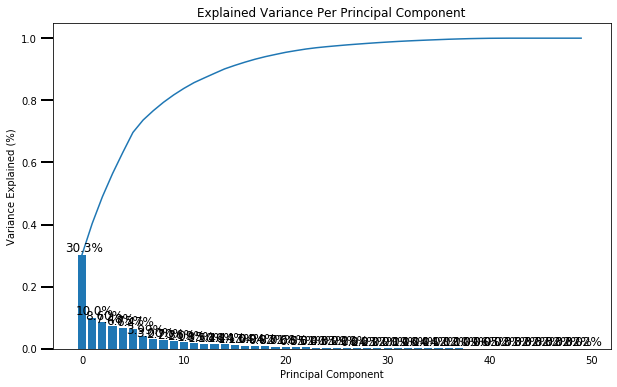

In [238]:
scree_plot(pca)

In [240]:
pca = PCA(n_components=50)
dffinal_pca_50 = pca.fit_transform(dffinal_scaled)

pca_30 = PCA(n_components=30)
dffinal_pca_30  = pca_30.fit_transform(dffinal_scaled)
pca_20 = PCA(n_components=20)
dffinal_pca_20  = pca_20.fit_transform(dffinal_scaled)
pca_10 = PCA(n_components=10)
dffinal_pca_10 = pca_10.fit_transform(dffinal_scaled)

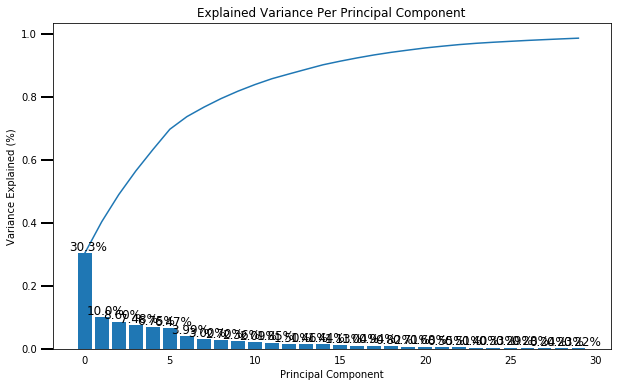

In [241]:
scree_plot(pca_30)

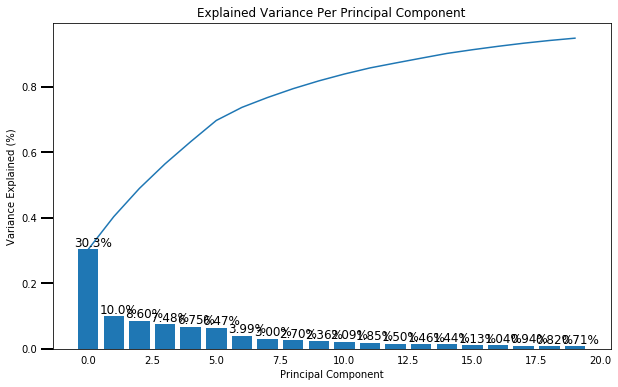

In [242]:
scree_plot(pca_20)

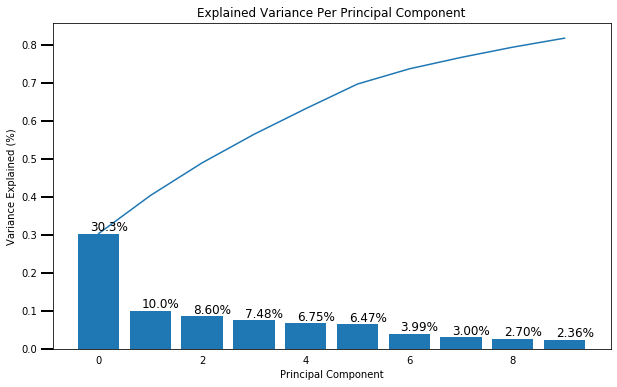

In [243]:
scree_plot(pca_10)

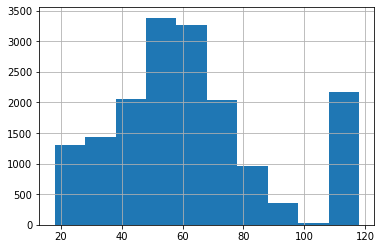

In [214]:
profile.age.hist()

#### 2.1.1.1 Exploratory 

There are 17,000 unique users. Out of those, 2,175 (~12%) don't have their gender and income information available. Judging from unique IDs, there seems to be no duplicate. As of for format, "became_member_on" column has yet formatted as date. 

Age wise, most users are  relatively old since ~75% of them are older than 45Y (might due to encryption?). Male account for more than half of gender identified customers.

In [ ]:
### 2.1.2 Portfolio

In [ ]:
### 2.1.2 Transcript

In [ ]:
transcript.head(5)

In [ ]:
transcript.event.unique().tolist()

In [ ]:
transcript[transcript.event=='offer received'].head(1)

In [ ]:
transcript[transcript.event=='offer viewed'].head(1)

In [ ]:
transcript[transcript.event=='transaction'].head(1)

In [ ]:
transcript[transcript.event=='offer completed'].iloc[1,:].value

In [ ]:
profile.head(5)

In [ ]:
portfolio.head(5)

In [ ]:
##### KMeans #####
##### Agglomerative Clustering #####
##### DBSCAN #####
##### MEAN SHIFT #####

The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.